# Environment and Dependency Check
This section verifies that the notebook is running inside the configured `msl` environment and that the numerical/plotting dependencies required for the coverage heatmaps are importable.


In [1]:
import sys
from pathlib import Path

import h5py
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

print(f"Python version: {sys.version.split()[0]}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Matplotlib version: {matplotlib.__version__}")
print(f"Seaborn version: {sns.__version__}")
print(f"h5py version: {h5py.__version__}")

sns.set_theme(style="whitegrid", context="notebook")
PROJECT_ROOT = Path.cwd().resolve().parent
DATA_PATH = PROJECT_ROOT / "data" / "band_library.h5"
print(f"Project root: {PROJECT_ROOT}")
print(f"Band library path: {DATA_PATH}")
if DATA_PATH.exists():
    print(f"HDF5 file size: {DATA_PATH.stat().st_size / 1_048_576:.2f} MiB")
else:
    raise FileNotFoundError(
        "Expected band_library.h5 is missing. Run a scan before using this notebook."
    )


Python version: 3.12.12
NumPy version: 2.1.3
Pandas version: 2.3.3
Matplotlib version: 3.10.8
Seaborn version: 0.13.2
h5py version: 3.15.1
Project root: /home/renlephy/msl/research/band_diagram_scan
Band library path: /home/renlephy/msl/research/band_diagram_scan/data/band_library.h5
HDF5 file size: 24.62 MiB


## Dataset Discovery and Inventory
We enumerate every scan group inside `band_library.h5`, pull the axis metadata, and tabulate availability for every `(lattice, r/a, \epsilon_{bg})` combination. Polarization completeness is tracked separately for TE and TM to highlight partially evaluated geometries.


In [2]:
from typing import Dict, List, Tuple

STATUS_COMPLETE = 1
POL_TE = "TE"
POL_TM = "TM"

def list_scans(h5_path: Path) -> List[str]:
    with h5py.File(h5_path, "r") as h5:
        scans = h5.get("scans")
        if scans is None:
            return []
        return list(scans.keys())


def compute_availability_table(h5_path: Path, scan_id: str | None = None) -> pd.DataFrame:
    with h5py.File(h5_path, "r") as h5:
        scans_grp = h5["scans"]
        target_scan = scan_id or next(iter(scans_grp.keys()))
        if target_scan not in scans_grp:
            raise KeyError(f"Scan '{target_scan}' not found in {h5_path}")
        scan = scans_grp[target_scan]
        axes_grp = scan["axes"]
        lattice_types = axes_grp["lattice_type"].asstr()[...].tolist()
        polarizations = axes_grp["polarization"].asstr()[...].tolist()
        eps_axis = axes_grp["eps_bg"][...]
        r_axis = axes_grp["r_over_a"][...]
        status = scan["status"]["geom_status"][...]
        rows: List[Dict[str, object]] = []
        for i_lat, lattice in enumerate(lattice_types):
            for i_eps, eps_val in enumerate(eps_axis):
                for i_r, r_val in enumerate(r_axis):
                    pol_status = {
                        polarizations[i_pol].upper(): status[i_lat, i_pol, 0, i_eps, i_r]
                        for i_pol in range(len(polarizations))
                    }
                    te_complete = pol_status.get(POL_TE, 0) == STATUS_COMPLETE
                    tm_complete = pol_status.get(POL_TM, 0) == STATUS_COMPLETE
                    if te_complete and tm_complete:
                        coverage_code = 3
                    elif te_complete:
                        coverage_code = 1
                    elif tm_complete:
                        coverage_code = 2
                    else:
                        coverage_code = 0
                    rows.append(
                        {
                            "scan_id": target_scan,
                            "lattice": lattice,
                            "epsilon_bg": float(eps_val),
                            "r_over_a": float(r_val),
                            "te_complete": te_complete,
                            "tm_complete": tm_complete,
                            "coverage_code": coverage_code,
                        }
                    )
    df = pd.DataFrame(rows)
    return df.sort_values(["lattice", "r_over_a", "epsilon_bg"]).reset_index(drop=True)


available_scans = list_scans(DATA_PATH)
if not available_scans:
    raise RuntimeError("No scans found. Run `bandlib run ...` before using the visualization notebook.")

TARGET_SCAN = available_scans[0]
availability_df = compute_availability_table(DATA_PATH, TARGET_SCAN)
print(f"Detected scans: {available_scans}")
print(f"Using scan: {TARGET_SCAN}")
display(availability_df.head())
print(f"Total parameter points tracked: {len(availability_df):,}")


Detected scans: ['square_hex_eps_r_v1', 'tiny_debug']
Using scan: square_hex_eps_r_v1


,scan_id,lattice,epsilon_bg,r_over_a,te_complete,tm_complete,coverage_code
0,square_hex_eps_r_v1,hex,1.8,0.1,False,False,0
1,square_hex_eps_r_v1,hex,1.9,0.1,False,False,0
2,square_hex_eps_r_v1,hex,2.0,0.1,False,False,0
3,square_hex_eps_r_v1,hex,2.1,0.1,False,False,0
4,square_hex_eps_r_v1,hex,2.2,0.1,False,False,0


Total parameter points tracked: 9,594


## Parameter Grid Preparation
We reshape the availability table into dense 2D grids (rows = r/a samples, columns = background permittivity samples) for each lattice. Missing entries remain in the grid so that whitesmoke can reveal gaps directly.


In [3]:
def build_parameter_grids(df: pd.DataFrame) -> Dict[str, Dict[str, np.ndarray]]:
    grids: Dict[str, Dict[str, np.ndarray]] = {}
    for lattice, lattice_df in df.groupby("lattice"):
        pivot = lattice_df.pivot(index="r_over_a", columns="epsilon_bg", values="coverage_code")
        pivot = pivot.sort_index().sort_index(axis=1)
        grids[lattice] = {
            "matrix": pivot.values.astype(int),
            "r_values": pivot.index.to_numpy(),
            "eps_values": pivot.columns.to_numpy(),
        }
    return grids


def summarize_grids(grids: Dict[str, Dict[str, np.ndarray]]) -> pd.DataFrame:
    rows = []
    for lattice, payload in grids.items():
        matrix = payload["matrix"]
        rows.append(
            {
                "lattice": lattice,
                "r_points": matrix.shape[0],
                "epsilon_points": matrix.shape[1],
                "cells": matrix.size,
                "covered_cells": int(np.count_nonzero(matrix)),
            }
        )
    return pd.DataFrame(rows)


lattice_grids = build_parameter_grids(availability_df)
summary_df = summarize_grids(lattice_grids)
display(summary_df)


,lattice,r_points,epsilon_points,cells,covered_cells
0,hex,39,123,4797,0
1,square,39,123,4797,4796


## Heatmap Rendering – Square Lattice
Each colored marker sits at the center of a parameter cell atop a whitesmoke background. Red markers indicate TE-only coverage, blue markers indicate TM-only coverage, and dark smokey green markers indicate that both polarizations are complete.


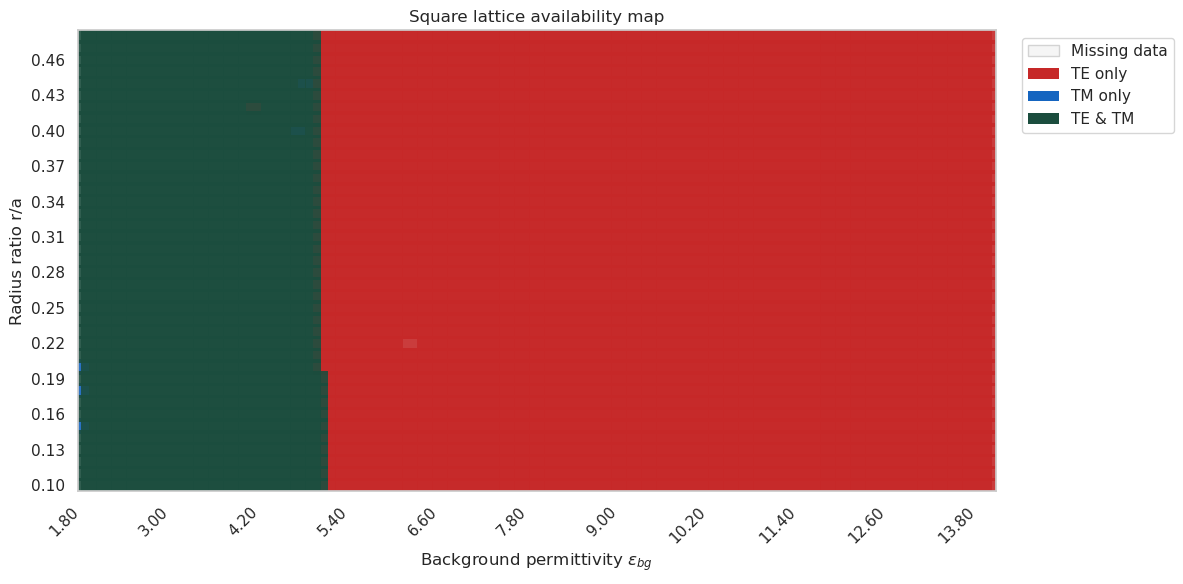

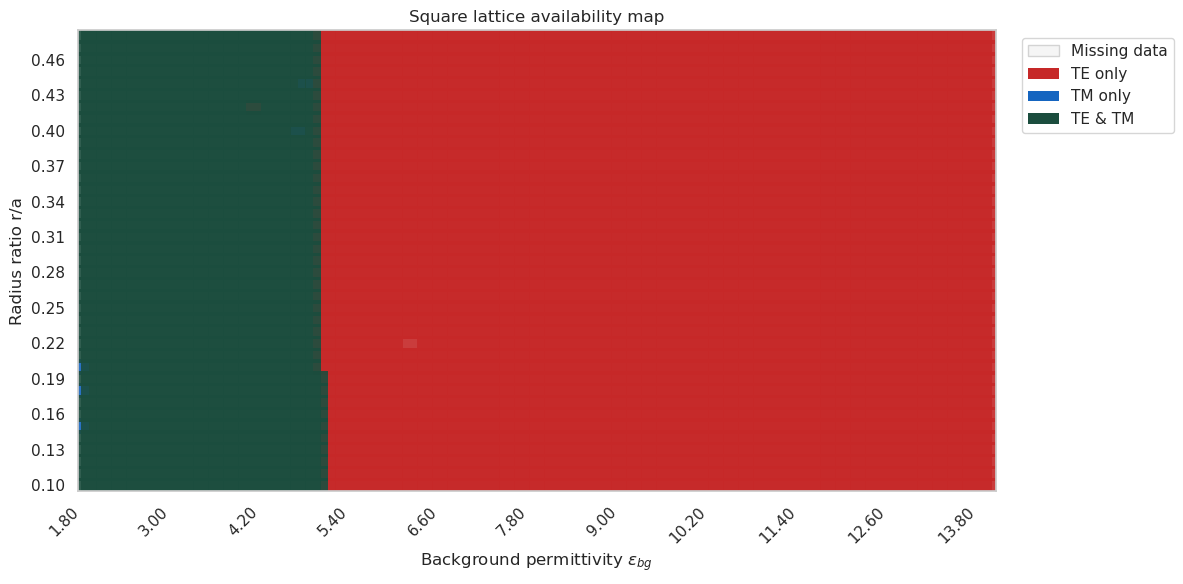

In [4]:
from matplotlib.patches import Patch

COLOR_MAP = {
    1: ("#c62828", "TE only"),
    2: ("#1565c0", "TM only"),
    3: ("#1b4d3e", "TE & TM"),
}
BASE_CMAP = matplotlib.colors.ListedColormap(["whitesmoke"])
heatmap_stats: Dict[str, Dict[str, int]] = {}


def _format_axis_ticks(ax: plt.Axes, values: np.ndarray, axis: str) -> None:
    if values.size == 0:
        return
    step = max(1, values.size // 10)
    idxs = np.arange(values.size)[::step]
    labels = [f"{values[i]:.2f}" for i in idxs]
    if axis == "x":
        ax.set_xticks(idxs)
        ax.set_xticklabels(labels, rotation=45, ha="right")
    else:
        ax.set_yticks(idxs)
        ax.set_yticklabels(labels)


def plot_lattice_availability(lattice: str) -> Tuple[plt.Figure, plt.Axes]:
    if lattice not in lattice_grids:
        raise KeyError(f"Lattice '{lattice}' not present in the dataset")
    payload = lattice_grids[lattice]
    matrix = payload["matrix"]
    r_vals = payload["r_values"]
    eps_vals = payload["eps_values"]

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.imshow(
        np.zeros_like(matrix),
        cmap=BASE_CMAP,
        origin="lower",
        aspect="auto",
        extent=(-0.5, matrix.shape[1] - 0.5, -0.5, matrix.shape[0] - 0.5),
    )

    col_coords, row_coords = np.meshgrid(
        np.arange(matrix.shape[1]), np.arange(matrix.shape[0])
    )
    for code, (color, label) in COLOR_MAP.items():
        mask = matrix == code
        if np.any(mask):
            ax.scatter(
                col_coords[mask],
                row_coords[mask],
                c=color,
                marker="s",
                s=120,
                edgecolors="none",
                label=label,
                alpha=0.9,
            )
    ax.set_title(f"{lattice.title()} lattice availability map")
    ax.set_xlabel("Background permittivity $\\epsilon_{bg}$")
    ax.set_ylabel("Radius ratio r/a")
    ax.set_xlim(-0.5, matrix.shape[1] - 0.5)
    ax.set_ylim(-0.5, matrix.shape[0] - 0.5)
    _format_axis_ticks(ax, eps_vals, axis="x")
    _format_axis_ticks(ax, r_vals, axis="y")

    legend_handles = [Patch(facecolor="whitesmoke", edgecolor="lightgray", label="Missing data")]
    for _, (color, label) in COLOR_MAP.items():
        legend_handles.append(Patch(facecolor=color, edgecolor="none", label=label))
    ax.legend(handles=legend_handles, bbox_to_anchor=(1.02, 1), loc="upper left")
    ax.grid(False)

    heatmap_stats[lattice] = {
        "cells": int(matrix.size),
        "te_only": int(np.sum(matrix == 1)),
        "tm_only": int(np.sum(matrix == 2)),
        "both": int(np.sum(matrix == 3)),
    }
    return fig, ax


fig_square, ax_square = plot_lattice_availability("square")
fig_square.tight_layout()
fig_square


## Heatmap Rendering – Hexagonal Lattice
The same visualization recipe is repeated for the hexagonal lattice to reveal coverage gaps unique to that geometry.


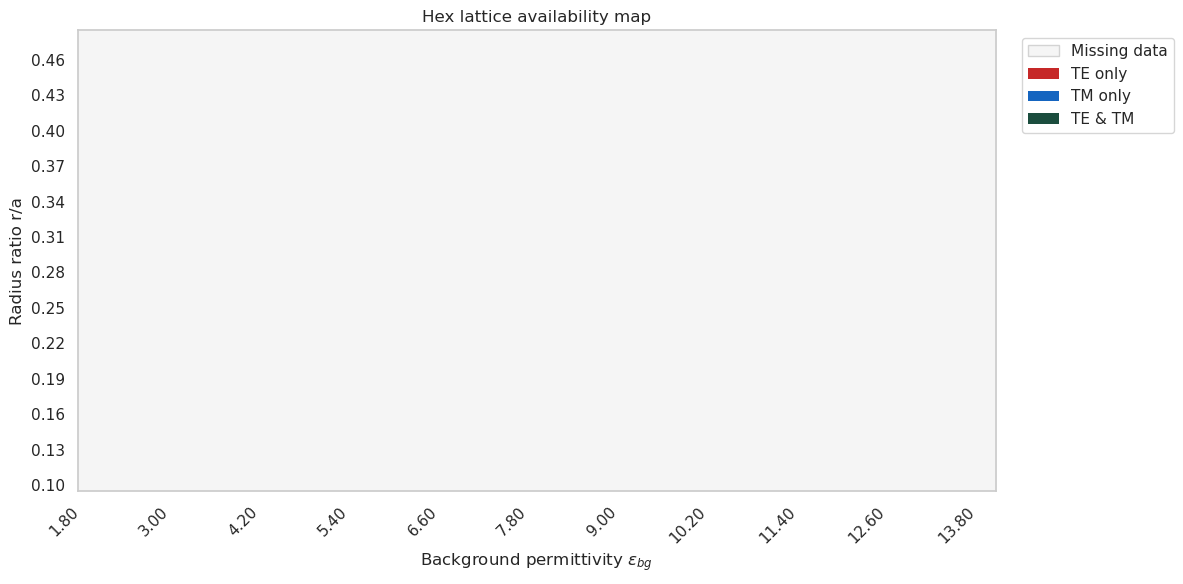

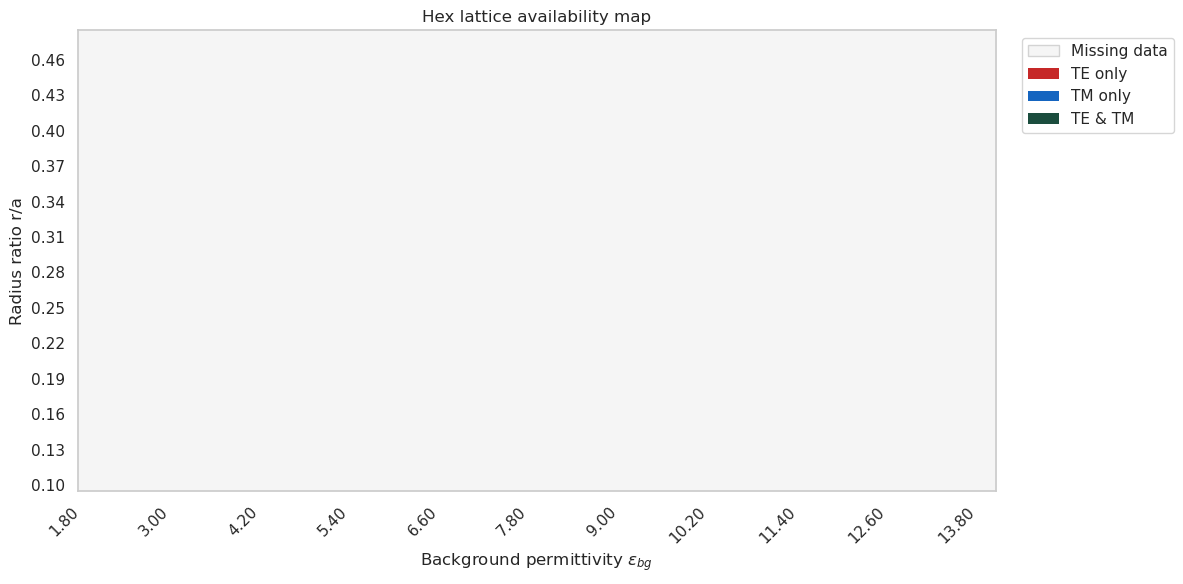

In [5]:
fig_hex, ax_hex = plot_lattice_availability("hex")
fig_hex.tight_layout()
fig_hex


## Pipeline Validation and Readiness Check
We treat this notebook like a lightweight test: verify that every lattice grid has the expected number of cells, ensure coverage codes stay within the defined palette, and summarize TE/TM completeness counts.


In [6]:
valid_codes = {0, 1, 2, 3}
observed_codes = set(availability_df["coverage_code"].unique())
assert observed_codes.issubset(valid_codes), f"Unexpected coverage codes: {observed_codes - valid_codes}"

for lattice, grid in lattice_grids.items():
    expected_cells = grid["matrix"].shape[0] * grid["matrix"].shape[1]
    assert heatmap_stats[lattice]["cells"] == expected_cells, "Cell count mismatch"
    print(
        f"{lattice.title():<7} | cells={expected_cells:,} | "
        f"TE-only={heatmap_stats[lattice]['te_only']:,} | TM-only={heatmap_stats[lattice]['tm_only']:,} | "
        f"Full={heatmap_stats[lattice]['both']:,}"
    )

coverage_summary = (
    availability_df.groupby(["lattice", "coverage_code"]).size().unstack(fill_value=0)
)
coverage_summary = coverage_summary.rename(columns={0: "missing", 1: "TE only", 2: "TM only", 3: "TE & TM"})
coverage_summary


Hex     | cells=4,797 | TE-only=0 | TM-only=0 | Full=0
Square  | cells=4,797 | TE-only=3,539 | TM-only=5 | Full=1,252


coverage_code,missing,TE only,TM only,TE & TM
lattice,,,,
hex,4797,0,0,0
square,1,3539,5,1252


## Execution Command
Use the following shell snippets from the repository root:

- Execute this notebook headlessly and store the rendered output:

  ```bash
  mamba run -n msl jupyter nbconvert --to notebook --execute notebooks/data_availability.ipynb \
    --output notebooks/data_availability.executed.ipynb
  ```

- Launch the full MPB sweep (single-process; MPB manages its own parallelism):

  ```bash
  mamba run -n msl bandlib run config/scan_square_hex_eps_r_v1.yml --h5 data/band_library.h5 --solver mpb
  ```
